In [1]:
import time, requests, datetime, traceback, io, json

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
import pydocmaker as pyd

In [4]:
# this is how to install a device library
# %pip install mke_sculib -U
# Or from a self hosted pip server
# %pip install --index-url http://10.98.76.45:30021/simple/ mke_client --trusted-host 10.98.76.45 -U


In [5]:
# # This is how to test / show what version is being used
# import mke_sculib
# try:
#     print('mke_sculib --> v' + str(mke_sculib.__version__), mke_sculib.__file__)
# except: 
#     print('mke_sculib --> NO VERSION AVAILABLE')

In [6]:
# this is a quick and dirty way to check if the version is OK
# assert mke_sculib.__version__ >= '2.5.5'

In [7]:
t_script_start = datetime.datetime.utcnow()

___
# EXAMPLE FUNCTIONAL TEST
___


This is an example on how one could run a functional test


In [8]:
# NOTE: The string or node provided for parameters must be self contained and only consist of the following Python literal structures: 
# strings, bytes, numbers, tuples, lists, dicts, sets, booleans, and None

## Parameters

In [9]:
# Auto generated Parameters
script_id = 0
dbserver_uri = "http://localhost:8000"
url = "http://localhost:8000"
device_id = ''

script_name = "02_example_functional_test"
script_version = "dirty_wip"
script_in_path = ""
script_out_path = ""
default_data_dir = ""

start_condition = "2024-09-05T15:52:03.463362Z"
end_condition = "2024-09-06T15:52:03.463362Z"
time_initiated = "2024-09-05T15:52:03.463362Z"
time_started = "2024-09-05T15:52:03.463362Z"
time_finished = "2024-09-05T15:52:03.463362Z"
status = "STARTING"
errors = ""
comments = ""
docs_json = {}
papermill_json = None
data_json = {}
last_time_changed = "2024-09-05T15:52:24.066754Z"
device = []
datafiles = []

follow_up_script = {"script_in_path": "", "script_params_json": {}}


# manual parameters
do_upload = 0
add_test_info_to_rep = 1


on_start = [
    'connect',
]

testcases = []
# [
    # {
    #     'name': 'test01',
    #     'cmds': [
    #         {
    #             'fun': 'setup',
    #             'args' [],
    #             'kwargs': {},
    #             'expects': [{
    #                 'fun': 'get_status',
    #                 'result_value', True,
    #                 'condition': '=='
    #             }]
    #         }
    #     ]
    # }
# ]

on_exit = [
    
]

## Preparation

In [10]:
# this is where we will save the results
results = []

# this is where we will compile a report
doc = pyd.DocBuilder()



In [11]:
txt = f"""This is a functional test for the device with the `{device_id=}` tested within the script with `{script_id=}`  
and `{script_name=}` (`{script_version=}`) at starting time: `{time_started}`.
The full script information will be given in the annex."""

doc.add_kw('markdown', txt, chapter='Introduction')

## Helpers

In [12]:
def get_me():
    r = requests.get(f'{dbserver_uri}/script_full/{script_id}')
    r.raise_for_status()
    return r.json()



In [13]:
def upload_file(filename:str, byte_data:bytes, mimetype='text/plain'):
    """this is how to upload a file

    Args:
        filename (str): the filename e.g. mytestfile.txt
        byte_data (bytes): the file content as bytes or string
        mimetype (str, optional): the file mimetype. Defaults to 'text/plain'.

    Returns:
        dict: the response from "/action/script/{script_id}/upload/files route"
    """

    url = f'{dbserver_uri}/action/script/{script_id}/upload/files'

    if isinstance(byte_data, str):
        byte_data = byte_data.encode()

    # Send the request with bytes as a file
    files = {'files': (filename, io.BytesIO(byte_data), mimetype)}

    response = requests.post(url, files=files)
    response.raise_for_status()
    return response.json()

def upload_doc(doc, report_name='', as_loose_doc=False):
    """Uploads a document to the server.

    Args:
        doc (DocBuilder): The document to upload.
        report_name (str, optional): The name of the uploaded document. Defaults to a timestamp-based name assigned by the backend.
        as_loose_doc (bool, optional): Whether to upload the document as a loose document (detached from the currently running script). Defaults to False.

    Returns:
        dict: The JSON response from the server after uploading the document.
    """
    
    if as_loose_doc:
        url = f'{dbserver_uri}/doc/upload'
    else:
        url = f'{dbserver_uri}/action/script/{script_id}/upload/doc'

    return doc.upload(url, report_name)


In [14]:
import contextlib
import io
import sys

@contextlib.contextmanager
def capture_print_output():
    old_stdout = sys.stdout
    new_stdout = io.StringIO()
    sys.stdout = new_stdout
    try:
        yield new_stdout
    finally:
        sys.stdout = old_stdout


In [15]:


# helper function instead of assert
def asserte(err, to_test, message, do_print=True):
    if not to_test:
        if do_print:
            print_color('Testcondition failed. Message: ' + message, 'red')
        return err + 'ERROR: ' + message + '\n'
    else:
        return err
    
import functools


class colors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    BLACK = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

colors_dc = {
    'header': colors.HEADER,
    'blue': colors.OKBLUE,
    'green': colors.OKGREEN,
    'warn': colors.WARNING,
    'red': colors.FAIL,
    'black': colors.BLACK,
    'bold': colors.BOLD,
    'underline': colors.UNDERLINE
}

_print = print

def print_color(msg, color='red'):
    if isinstance(color, str):
        color = colors_dc[color]
    if print.do_log:
        print.log.append(msg)
    _print(f"{color}{msg}{colors.BLACK}")

def print(*args, **kwargs):
    if print.do_log:
        print.log.append(''.join([str(arg) for arg in args]))
    _print(kwargs)

print.log = []
print.do_log = False

def testcase(_func=None, *, test_name='', func_to_get_chan_values=None, expected_chan_values=None, n_repeat=1):

    def decorator_name(func):
        @functools.wraps(func)
        def wrapper():
            global results

            for i in range(n_repeat):
                print.log.clear()
                print.do_log = True
            
                fname = 'TESTCASE No. {: 4d} | "{}"'.format(len(results), func.__name__)
                if test_name:
                    fname += f' | "{test_name}"'
                    
                name = func.__name__ if not test_name else test_name

                print_color((('-'*20) + ' RUNNING ' + fname + '-'*20).ljust(100, '-'), 'bold')
                print_color(fname + 'running...', 'blue')

                t_start = datetime.datetime.utcnow()
                time.sleep(0.1)
                

                try:
                    
                    # RUN the Testcase
                    
                    err = func()

                    assert not err is None, 'every testcase need to return an error string. Please return "" (empty string) if you have no error '
                    if err is None:
                        err = ''
                    
                    
                except Exception as err_obj:   
                    print_color(fname + '--> FAIL', 'red')
                    s = 'ERROR while executing:\n' + traceback.format_exc()
                    print_color(s, 'red')
                    # ADD TO RESULTS
                    results.append((name, s))
                    return 
                
                if err:
                    print_color(fname + '--> FAIL', 'red')
                else:
                    print_color(fname + '--> OK', 'green')

                time.sleep(0.1)
                t_end = datetime.datetime.utcnow()

                # ---------------
                # TEST ERROR CHANNELS
                # ---------------
                if expected_chan_values and func_to_get_chan_values:
                    print_color(fname + 'testing for channel errors...', 'blue')

                    chans = func_to_get_chan_values(expected_chan_values.keys(), t_start, t_end)
                    err_chans = [c for c in expected_chan_values if expected_chan_values[c](chans[c]) ]

                    if err_chans:
                        err += 'Error on channel(s): ' + ', '.join(err_chans) + '\n'
                        print_color(fname + '--> FAIL', 'red')
                    else:
                        print_color(fname + '--> OK', 'green')

                
                print_color((('-'*10) + ' DONE ' + ('-'*10)).ljust(100, '-'), 'header')
                if err:
                    s = fname + '--> FAILED!'
                    s += '\n' + err

                    print_color(s, 'red')
                    print_color('-'*100, 'red')
                else:
                    s = fname + '--> SUCCESS!'
                    print_color(s, 'green')
                    print_color('-'*100, 'green')

                print.do_log = False
                txt = '\n'.join(print.log)
                    
                    
                if add_test_info_to_rep:
                    doc.add_kw('markdown', '#### ' + fname + '\n this is the individual test output while running the test:\n\n', chapter='Testcases')
                    
                    for c in colors_dc.values():
                        txt = txt.replace(c, '')
                    doc.add_kw('verbatim', txt, chapter='Testcases')
                    # doc.add_kw('verbatim', '\n'.join(print_color.log), chapter='Testcases')


                # ADD TO RESULTS
                results.append((name, err))
                

        return wrapper
    
    if _func is None:
        return decorator_name                      # 2
    else:
        return decorator_name(_func)               # 3
    
    


In [16]:
dbserver_uri

'http://localhost:8000'

## Some Dummy Device

In [17]:
class DummyDevice():
    """A dummy device class for testing purposes.

    This class provides methods to simulate the behavior of a real device, such as
    retrieving historical data, getting channel values, checking the device state,
    and executing commands.

    Methods:
        get_history(channels=None, t_min=None, t_max=None):
            Retrieves historical data for the specified channels within a given time range.
        get_chans(channels):
            Gets the current values for the specified channels.
        get_state():
            Gets the current state of the device (RUNNING or STOPPED).
        command(action, *args, **kwargs):
            Simulates executing a command on the device.
    """

    def get_history(self, channels=None, t_min=None, t_max=None):
        if t_max is None:
            t_max = datetime.datetime.utcnow()
        if t_min is None:
            t_min = datetime.datetime.utcnow() - datetime.timedelta(seconds=20)


        # generate a dummy measurementpoint for every 0.01 seconds
        if channels is None:
            channels = [f'dummy_channel_{i}' for i in range(3)]
        td = np.ptp([t_min, t_max]).total_seconds()
        n = int(td / 0.01)
        return {c:np.cumsum(np.random.randn(n)) for c in channels}
    
    def get_chans(self, channels):
        return {c:np.random.randn() for c in channels}
    
    def get_state(self):
        return 'RUNNING' if np.random.randn() > 0.0 else 'STOPPED'
    
    def command(self, action, *args, **kwargs):
        print(f'dummy command with {action=} {args=} {kwargs=}')

device = DummyDevice()


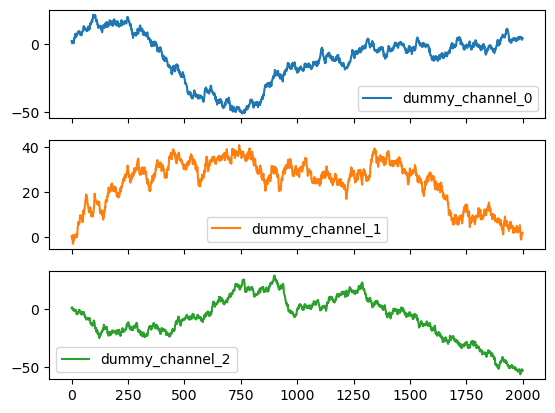

In [18]:

txt = f"""
The device under test is of type `{type(device)}`. The history at start of the test is shown in the plot below.
"""

doc.add_kw('markdown', txt, chapter='Device Info')



pd.DataFrame(device.get_history()).plot(subplots=True)

doc.add_fig(caption='This is the device history for dt=20s before starting of the functional tests')


txt = 'STATE 10 times before functional testing:\n\n'
for i in range(10):
    txt += f'{i=} | {time.time_ns()=} | {device.get_state()=}\n'
doc.add_kw('verbatim', txt, chapter='Device Info')


## Some Example Tests

In [19]:
script_id = 1

In [20]:
# def connect(device):
#     # put connect logic in here
#     pass
    
#     lib = device['connection_library']
#     if lib == 'katcp':
#         import katcp as api
#     elif lib == 'sculib':
#         import mke_sculib as api
#     else:
#         raise Exception(f'given {lib} not found!')

In [21]:
# for i, testcase in enumerate(testcases):
#     print(f'TESTCASE: {i}/{len(testcases}: {testcase["name"]}')
    
#    assert katcp.get_channel('4711') == result_value
                           
#     for cmd 
    

In [22]:
@testcase # this will just test if a testcase runs through and returns an error
def test_1():
    err = ''
    # this will PASS
    return err
test_1()

-------------------- RUNNING TESTCASE No.    0 | "test_1"-------------------------------------------
TESTCASE No.    0 | "test_1"running...
TESTCASE No.    0 | "test_1"--> OK
---------- DONE ------------------------------------------------------------------------------------
TESTCASE No.    0 | "test_1"--> SUCCESS!
----------------------------------------------------------------------------------------------------


In [23]:
@testcase # this will just test if a testcase runs through and returns an error
def test_2():
    err = ''
    err += 'SOME ERROR'
    # this will FAIL
    return err

test_2()

-------------------- RUNNING TESTCASE No.    1 | "test_2"-------------------------------------------
TESTCASE No.    1 | "test_2"running...
TESTCASE No.    1 | "test_2"--> FAIL
---------- DONE ------------------------------------------------------------------------------------
TESTCASE No.    1 | "test_2"--> FAILED!
SOME ERROR
----------------------------------------------------------------------------------------------------


In [24]:
@testcase # this will just test if a testcase runs through and returns an error
def test_3():
    err = ''
    assert False, 'This is also a fail condition'
    return err

test_3()

-------------------- RUNNING TESTCASE No.    2 | "test_3"-------------------------------------------
TESTCASE No.    2 | "test_3"running...
TESTCASE No.    2 | "test_3"--> FAIL
ERROR while executing:
Traceback (most recent call last):
  File "C:\Users\tglaubach\AppData\Local\Temp\ipykernel_230640\864850057.py", line 79, in wrapper
    err = func()
          ^^^^^^
  File "C:\Users\tglaubach\AppData\Local\Temp\ipykernel_230640\1187964800.py", line 4, in test_3
    assert False, 'This is also a fail condition'
AssertionError: This is also a fail condition



In [25]:
@testcase(n_repeat=3)
def test_is_running():
    err = ''
    err = asserte(err, device.get_state() == 'RUNNING', 'device is not running!')
    time.sleep(2)
    print('sleeping for 2s...')
    return err

test_is_running()

-------------------- RUNNING TESTCASE No.    3 | "test_is_running"----------------------------------
TESTCASE No.    3 | "test_is_running"running...
Testcondition failed. Message: device is not running!
{}
TESTCASE No.    3 | "test_is_running"--> FAIL
---------- DONE ------------------------------------------------------------------------------------
TESTCASE No.    3 | "test_is_running"--> FAILED!
ERROR: device is not running!

----------------------------------------------------------------------------------------------------
-------------------- RUNNING TESTCASE No.    4 | "test_is_running"----------------------------------
TESTCASE No.    4 | "test_is_running"running...
Testcondition failed. Message: device is not running!
{}
TESTCASE No.    4 | "test_is_running"--> FAIL
---------- DONE ------------------------------------------------------------------------------------
TESTCASE No.    4 | "test_is_running"--> FAILED!
ERROR: device is not running!

---------------------------------

In [26]:

@testcase(
        func_to_get_chan_values=device.get_history, 
        expected_chan_values={
            'mychannel_1': lambda x: np.all(x < 10),
            'mychannel_2': lambda x: np.all(x > 150),
        })
def test_never_too_high():
    # this will run some tests and check, that the data is never too high for the duration of the test (will only check after the test is done)
    device.command('start')
    device.command('change_config', 'abc')
    time.sleep(2)
    print(device.get_chans('mychannel_1 mychannel_2'.split()))

    device.command('stop')    
    return ''

test_never_too_high()

-------------------- RUNNING TESTCASE No.    6 | "test_never_too_high"------------------------------
TESTCASE No.    6 | "test_never_too_high"running...
{}
{}
{}
{}
TESTCASE No.    6 | "test_never_too_high"--> OK
TESTCASE No.    6 | "test_never_too_high"testing for channel errors...
TESTCASE No.    6 | "test_never_too_high"--> OK
---------- DONE ------------------------------------------------------------------------------------
TESTCASE No.    6 | "test_never_too_high"--> SUCCESS!
----------------------------------------------------------------------------------------------------


___
# RESULTS
___

In [27]:
t_script_end = datetime.datetime.utcnow()

In [28]:

print('=' * 100)
print_color('FINISHED!\nTESTED N={} testcases between {}...{} ({})'.format(t_script_start, t_script_end, t_script_end, t_script_start), 'bold')

print('RESULTS:')
print('-' * 60)

lines = []
has_err = False
err_s = ''
for i, (test_name, err_str) in enumerate(results):
    if err_str:
        has_err = True
        c = 'red'
        res = ' --> FAIL!'
    else:
        c = 'green'
        res = ' --> PASS!'
    
    line = 'TESTCASE No. {: 4.0f} | {} |> {}'.format(i, test_name.ljust(35), res)
    lines.append(line)
    
    if err_str:
        err_s += line + '\n'
        
    print_color(line, c)

print('=' * 100)

{}
FINISHED!
TESTED N=2024-09-05 19:53:40.945628 testcases between 2024-09-05 19:53:50.789701...2024-09-05 19:53:50.789701 (2024-09-05 19:53:40.945628)
{}
{}
TESTCASE No.    0 | test_1                              |>  --> PASS!
TESTCASE No.    1 | test_2                              |>  --> FAIL!
TESTCASE No.    2 | test_3                              |>  --> FAIL!
TESTCASE No.    3 | test_is_running                     |>  --> FAIL!
TESTCASE No.    4 | test_is_running                     |>  --> FAIL!
TESTCASE No.    5 | test_is_running                     |>  --> FAIL!
TESTCASE No.    6 | test_never_too_high                 |>  --> PASS!
{}


In [29]:
doc.add_kw('verbatim', '\n'.join(lines), chapter='Test Results')

doc.add('Shown below are the test results as JSON encoded text for further processing', chapter='Test Results')
doc.add_kw('verbatim', json.dumps(results, indent=2), chapter='Test Results')


## Write the Document to the Server

In [30]:

doc.add('Shown below is the script (status shortly before finishing) where this document was generated in:', chapter='Annex')

doc.add_kw('verbatim', json.dumps(get_me(), indent=2), chapter='Annex')


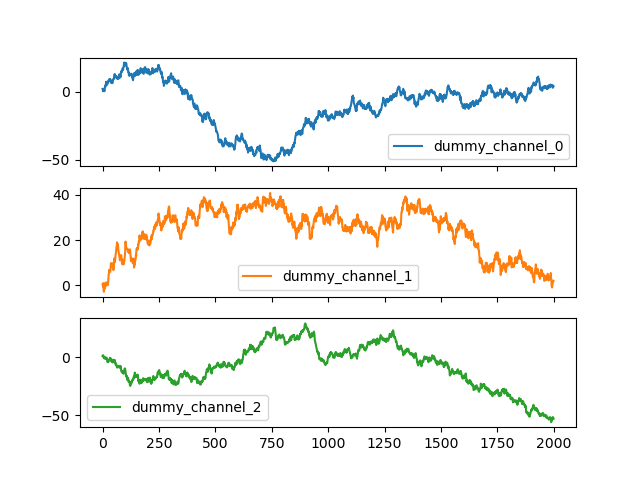

In [31]:
doc.show()

In [32]:
if do_upload:
    upload_doc(doc, as_loose_doc = script_id == 0)
else:
    print('SKIPPING UPLOAD!!!\n'*10)
    

{}


In [33]:
assert not has_err, err_s    

AssertionError: TESTCASE No.    1 | test_2                              |>  --> FAIL!
TESTCASE No.    2 | test_3                              |>  --> FAIL!
TESTCASE No.    3 | test_is_running                     |>  --> FAIL!
TESTCASE No.    4 | test_is_running                     |>  --> FAIL!
TESTCASE No.    5 | test_is_running                     |>  --> FAIL!
